In [1]:
text = 'You say goodbye and I say hello.'

In [2]:
text = text.lower()
print(text)
text = text.replace('.',' .')
print(text)

you say goodbye and i say hello.
you say goodbye and i say hello .


In [3]:
words = text.split(' ')
words

['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']

In [4]:
word_to_id = {}
id_to_word = {}

for word in words:
    if word not in word_to_id: # dict  in method for 'key'
        new_id = len(word_to_id)
        word_to_id[word] = new_id
        id_to_word[new_id] = word

In [5]:
id_to_word

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

In [6]:
word_to_id

{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}

In [7]:
id_to_word[1]

'say'

In [8]:
idx2word = {}
word2idx = {}
for w in words:
    if w not in word2idx:
        word2idx[w] = len(word2idx)
        idx2word[len(word2idx)] = w
    

In [9]:
word2idx

{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}

In [10]:
idx2word

{1: 'you', 2: 'say', 3: 'goodbye', 4: 'and', 5: 'i', 6: 'hello', 7: '.'}

In [11]:
import numpy as np
corpus = [word_to_id[w] for w in words]
corpus = np.array(corpus)
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

In [12]:
def preprocess(text):
    text = text.lower()
    text = text.replace('.',' .')
    words = text.split(' ')
    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
            
    corpus = np.array([word_to_id[w] for w in words])
    
    return corpus,word_to_id,id_to_word

In [13]:
corpus,word_to_id,id_to_word = preprocess(text)

In [14]:
print(corpus)
print(id_to_word)

[0 1 2 3 4 1 5 6 7]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '', 7: '.'}


In [15]:
def create_co_matrix(corpus, vocab_size, window_size = 1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size,vocab_size),dtype=np.int32)
    
    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size+1):
            left_idx = idx - i
            right_idx = idx + i
            
            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id,left_word_id] += 1
            
            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id,right_word_id] += 1
                
    return co_matrix

In [16]:
def cos_similarity(x,y,eps = 1e-8):
    nx = x/(np.sqrt(np.sum(x**2))+eps)
    ny = y/(np.sqrt(np.sum(y**2))+eps)
    
    return np.dot(nx,ny)

In [17]:
vocab_size = len(word_to_id) 
C = create_co_matrix(corpus,vocab_size)
c0 = C[word_to_id['you']]
c1 = C[word_to_id['i']]
print(cos_similarity(c0,c1))

0.7071067691154799


In [18]:
def most_similar(query,word_to_id,id_to_word,word_matrix,top=5):
    if query not in word_to_id:
        print("Can't find {}",format(query))
        return
    print('\n[query] '+query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]
    
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i],query_vec)
        
    count = 0
    for i in (-1*similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(' {}: {}'.format(id_to_word[i],similarity[i]))
        
        count += 1
        if count >=top:
            return
    

In [19]:
most_similar('you',word_to_id,id_to_word,C,top=5)


[query] you
 goodbye: 0.7071067691154799
 i: 0.7071067691154799
 hello: 0.7071067691154799
 say: 0.0
 and: 0.0


In [20]:
def ppmi(C, verbose=False, eps=1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C,axis=0)
    total = C.shape[0]*C.shape[1]
    cnt = 0
    k=0
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i,j]*N / (S[j]*S[i])+eps)
            M[i,j] = max(0,pmi)
            
            if verbose:
                cnt += 1
                
                if int((cnt/total)*100)  >= k:
                    k = int((cnt/total)*100)+10
                    print('{:.1f}%% Completed'.format(100*cnt/total))
    
    return M

In [21]:
text = "You say goodbye and I say hello."
corpus,word_to_id,id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus,vocab_size)
W = ppmi(C,True)

2.0%% Completed
12.2%% Completed
22.4%% Completed
32.7%% Completed
42.9%% Completed
53.1%% Completed
63.3%% Completed
73.5%% Completed
83.7%% Completed
93.9%% Completed


In [22]:
np.set_printoptions(precision=3)
print('Co-occur matrix')
print(C)
print('-'*50)
print('PPMI')
print(W)

Co-occur matrix
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


In [25]:
import matplotlib.pyplot as plt

In [26]:
U,S,V = np.linalg.svd(W)

In [28]:
print(U.shape,S.shape,V.shape)

(7, 7) (7,) (7, 7)


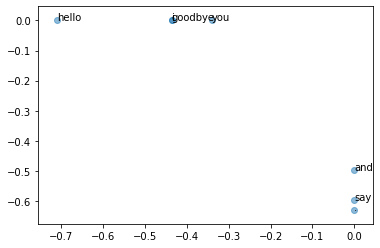

In [29]:
for word,word_id in word_to_id.items():
    plt.annotate(word,(U[word_id,0],U[word_id,1]))
plt.scatter(U[:,0],U[:,1],alpha=0.5)
plt.show()

In [33]:
U[0,:2]

array([-3.409e-01, -1.110e-16], dtype=float32)